In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt

%matplotlib inline  

client = MongoClient(port=27123)
db = client.frevue_data
coll = db.Trips
#cursor = coll.find({"Owner": "United Kingdom, London, UPS"})

# import data and extract list of data owner and the count of data entries for each data owner 

In [2]:
# this section check the number of partners in the database
# choose a partner and check the number of unique vehicles
# then for each vehicle check the number of available days

cursor1 = coll.aggregate([
        {"$group": {"_id": "$Owner", "NumberOfRecords": {"$sum": 1}}}
    ])
array = list(cursor1)
vehlist = pd.DataFrame(array)    #list of operation partners
print vehlist

    NumberOfRecords                                          _id
0               413                Netherlands, Rotterdam, EMOSS
1             12675      Netherlands, Amsterdam & Rotterdam, TNT
2               161              United Kingdom, London, Clipper
3              1096                        Portugal, Lisbon, CTT
4               541             Netherlands, Amsterdam, Heineken
5              1143  Spain, Madrid, Calidad Pascual & SEUR & TNT
6              1652                  Netherlands, Rotterdam, UPS
7              2987  Netherlands, Amsterdam & Rotterdam, TNT RAW
8               319             Netherlands, Rotterdam, Heineken
9              1589                       Portugal, Lisbon, EMEL
10            15800                  United Kingdom, London, UPS
11               68                          Italy, Milano, AMAT


# choose a data owner

In [3]:
curpartner = vehlist.iloc[0,1]   #current partner can set up a loop  ********************
print "current data owner selected is " + curpartner

current data owner selected is Netherlands, Rotterdam, EMOSS


# now extract the number of vehicles (vehicleid) available for the chosen partner and the number of days which data is available for each vehicle

In [11]:
# check valid recordings (distance bigger than 0)
cursor2 = coll.find(
        {"$and": [
                 {"Owner": curpartner},
                 {"Distance": {"$gt": 0}}
                ]
        })
PartnerData = pd.DataFrame(list(cursor2))
PartnerData['sday'] = [x.date() for x in PartnerData['StartTime']]
PartnerData['eday'] = [x.date() for x in PartnerData['EndTime']]
# printing
Veh_num = len(PartnerData['VehicleId'].unique()) #count the number of vehilces
print "Total number of vehicle is " + Veh_num    #number of vehicles

check = sum(PartnerData['sday'] <> PartnerData['eday'])
print "the number of a vehicle with different strip start and end dates" + check


2


# optional - if the number of vehicle with different trip start and end dates is not zero

In [16]:
PartnerData[PartnerData['sday'] <> PartnerData['eday']]

,Aggregation,DataPoints,Distance,Duration,EndTime,Extras,FileRelativePath,Frequency,Owner,StartTime,...,StateOfChargeEnd,StateOfChargeMax,StateOfChargeMin,StateOfChargeStart,StateOfChargeUp,TripId,VehicleId,_id,sday,eday
41,1,"[{u'extra_Kl15': False, u'soc': 36.8, u'extra_...",85985.0,85999,2015-10-01 21:53:19,"{u'DistanceGps': {u'_v': 82476.1465249, u'_t':...",rotterdam-emoss\2015-09-27-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2015-09-30 22:00:00,...,40.0,64.8,18.0,36.8,51.6,2015-10-01,27-BFR-9,57b7032169e7d91cd03859cb,2015-09-30,2015-10-01
42,1,"[{u'extra_Kl15': False, u'soc': 40.0, u'extra_...",46515.0,85096,2015-10-02 21:53:52,"{u'DistanceGps': {u'_v': 35094.0758856, u'_t':...",rotterdam-emoss\2015-09-27-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2015-10-01 22:15:36,...,75.2,75.2,40.0,40.0,54.0,2015-10-02,27-BFR-9,57b7032169e7d91cd03859cc,2015-10-01,2015-10-02
181,1,"[{u'extra_Kl15': False, u'soc': 76.0, u'extra_...",177970.0,55733,2016-01-28 14:30:16,"{u'DistanceGps': {u'_v': 167491.85049, u'_t': ...",rotterdam-emoss\2016-01-24-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2016-01-27 23:01:23,...,10.0,99.2,10.0,76.0,24.4,2016-01-28,27-BFR-9,57b7046069e7d91cd0385a7b,2016-01-27,2016-01-28
371,1,"[{u'extra_Kl15': False, u'soc': 90.0, u'extra_...",78665.0,85554,2016-07-08 21:59:58,"{u'DistanceGps': {u'_v': 73061.6227455, u'_t':...",rotterdam-emoss\2016-07-03-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2016-07-07 22:14:04,...,99.2,100.0,70.0,90.0,48.0,2016-07-08,27-BFR-9,57b705c969e7d91cd0385b65,2016-07-07,2016-07-08


# need to check whether there are multiple trips from a same vehicle in a single day

In [15]:
sum(PartnerData['sday'] <> PartnerData['eday'])

4

In [12]:
PartnerData.head(5)

,Aggregation,DataPoints,Distance,Duration,EndTime,Extras,FileRelativePath,Frequency,Owner,StartTime,...,StateOfChargeEnd,StateOfChargeMax,StateOfChargeMin,StateOfChargeStart,StateOfChargeUp,TripId,VehicleId,_id,sday,eday
0,1,"[{u'extra_Kl15': True, u'soc': 99.2, u'extra_E...",70640.0,20569,2015-08-31 10:54:07,"{u'DistanceGps': {u'_v': 69608.2630917, u'_t':...",rotterdam-emoss\2015-08-30-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2015-08-31 05:11:18,...,64.8,99.2,64.8,99.2,2.0,2015-08-31,12-BFB-3,57b702c769e7d91cd0385999,2015-08-31,2015-08-31
1,1,"[{u'extra_Kl15': True, u'soc': 100.0, u'extra_...",6880.0,2689,2015-09-01 14:38:42,"{u'DistanceGps': {u'_v': 6645.73727664, u'_t':...",rotterdam-emoss\2015-08-30-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2015-09-01 13:53:53,...,95.2,100.0,95.2,100.0,0.0,2015-09-01,12-BFB-3,57b702c769e7d91cd038599a,2015-09-01,2015-09-01
2,1,"[{u'extra_Kl15': True, u'soc': 99.2, u'extra_E...",30340.0,28257,2015-09-02 13:01:32,"{u'DistanceGps': {u'_v': 26484.3894568, u'_t':...",rotterdam-emoss\2015-08-30-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2015-09-02 05:10:35,...,83.2,99.2,83.2,99.2,1.6,2015-09-02,12-BFB-3,57b702c769e7d91cd038599b,2015-09-02,2015-09-02
3,1,"[{u'extra_Kl15': True, u'soc': 99.2, u'extra_E...",41145.0,20280,2015-09-03 16:14:20,"{u'DistanceGps': {u'_v': 40634.3824437, u'_t':...",rotterdam-emoss\2015-08-30-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2015-09-03 10:36:20,...,79.2,99.2,79.2,99.2,2.0,2015-09-03,12-BFB-3,57b702c769e7d91cd038599c,2015-09-03,2015-09-03
4,1,"[{u'extra_Kl15': True, u'soc': 99.2, u'extra_E...",114690.0,31579,2015-09-04 14:17:13,"{u'DistanceGps': {u'_v': 112334.162098, u'_t':...",rotterdam-emoss\2015-08-30-0000_weekly-export-...,1,"Netherlands, Rotterdam, EMOSS",2015-09-04 05:30:54,...,48.8,99.2,48.8,99.2,13.6,2015-09-04,12-BFB-3,57b702c769e7d91cd038599d,2015-09-04,2015-09-04


In [ ]:

# check how many days worth of data is availale for each vehicle
# PartnerData['newVID'] = PartnerData['VehicleId'].str[:6] ### ONLY FOR UPS (their data seems to have duplicate vehilces)
# Veh_num2 = len(PartnerData['newVID'].unique())
# print Veh_num2
#veh_days = pd.DataFrame(PartnerData.groupby('newVID').size().rename('numofdays'))
veh_days = pd.DataFrame(PartnerData.groupby('VehicleId').size().rename('numofdays'))
veh_days = veh_days.reset_index(range(veh_days.count()))
veh_days['VID'] = veh_days.index + 1
print veh_days
# merge to get unique vehilce ID for each vehicle (for plotting purpose)
#PartnerData = pd.merge(PartnerData, veh_days, left_on = "newVID", right_on = "newVID")
PartnerData = pd.merge(PartnerData, veh_days, left_on = "VehicleId", right_on = "VehicleId")
PartnerData['TripId'] = pd.to_datetime(PartnerData['TripId'])


(735602.0, 736300.0)

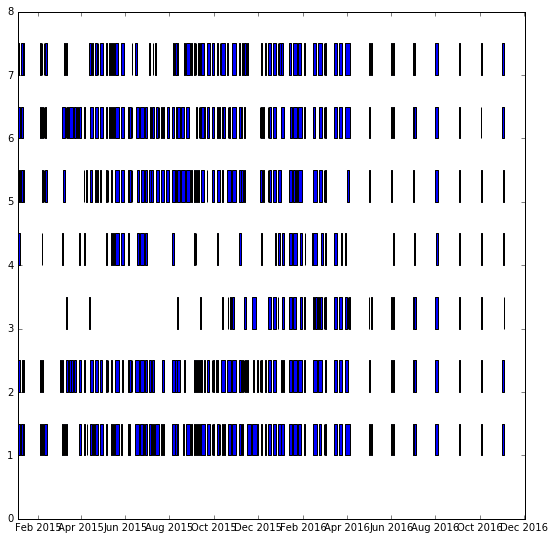

In [3]:
# plotting data availability
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)

for i in PartnerData['VehicleId'].unique():
    datelist = []
    selVehData = PartnerData[PartnerData['VehicleId']==i]
    curID = selVehData['VID'].iloc[0]
    sdate = selVehData['TripId'].min()
    edate = selVehData['TripId'].max()
    diffdate = edate - sdate
    dateswitch = 0
    curdate = sdate
    for j in range(0, int(diffdate.days)):
        predate = curdate                          #previous date
        curdate = curdate + dt.timedelta(days=1)     #current date
        if any(selVehData['TripId'] == curdate) and dateswitch == 1:
            sdate = curdate
            dateswitch = 0
        if (not any(selVehData['TripId'] == curdate)) and dateswitch == 0:   #if current date is not available, call plotting
            #pltmain(sdate, predate)
            datelist.append((mpl.dates.date2num(sdate), mpl.dates.date2num(curdate)-mpl.dates.date2num(sdate)))
            dateswitch = 1
    ax1.broken_barh(datelist, (curID,0.5))
ax1.xaxis_date()
ax1.set_xlim(PartnerData['TripId'].min(), PartnerData['TripId'].max())

In [ ]:
PartnerData.head(5)

In [ ]:
mpl.dates.date2num(dt.datetime.now())

In [ ]:
curdate = sdate + dt.timedelta(days=1)
print curdate
any(selVehData['TripId'] == curdate)

In [ ]:
#import datetime
#tt = datetime.datetime.strptime(PartnerData['TripId'], "%Y-%m-%d")
PartnerData['TripId'] = pd.to_datetime(PartnerData['TripId'])
#tt.apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2,2,1)
#for i in range(0, PartnerData['TripId'].count()):
ax1.broken_barh(PartnerData['TripId'], PartnerData['VID'])

In [ ]:
cursor = coll.find(
        {"$and": [
                 {"Owner": "United Kingdom, London, UPS"},
                 {"Distance": {"$gt": 0}}
                ]
        })
UPSLondon = pd.DataFrame(list(cursor))

In [ ]:
cursor2 = coll.aggregate([
    {"$match": {"$and": [
                        {"Owner": vehlist.iloc[0,1]}, 
                        {"Distance": {"$gt": 0}}
                ]}
    },
    {"$group": {"_id": "$VehicleId", "AverageDistance": {"$avg": "$Distance"}}}
])

In [ ]:
print PartnerData.head(n=10)
PartnerData.iloc[0,5]
len(PartnerData['VehicleId'].unique())

In [ ]:
cursor1 = coll.aggregate([
        {"$group": {"_id": "$Owner", "NumberOfTrips": {"$sum": 1}}}
    ])
array = list(cursor1)
vehlist = pd.DataFrame(array)    #list of operation partners
curpartner = vehlist.iloc[7,1]   #current partner can set up a loop  ********************
print curpartner